# Lab:15 Deep Reinforcement Learning
<hr>

110062802 呂宸漢


## Environment Setting

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [2]:
import os
from ple.games.flappybird import FlappyBird
from ple import PLE

os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line make pop-out window not appear

game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

test_game = FlappyBird()
test_env = PLE(test_game, fps=30, display_screen=False)
test_env.reset_game()


pygame 2.1.2 (SDL 2.0.18, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


## Parameter Setting

In [3]:
hparas = {
    'image_size': 84,
    'num_stack': 4,
    'action_dim': len(env.getActionSet()),
    'hidden_size': 256,
    'lr': 0.0001,
    'gamma': 0.99,
    'lambda': 0.95,
    'clip_val': 0.2,
    'ppo_epochs': 8,
    'test_epochs': 1,
    'num_steps': 512,
    'mini_batch_size': 64,
    'target_reward': 200,
    'max_episode': 30000,
}


## Utility Function

In [4]:
path = './movie_f'
if not os.path.exists(path):
    os.makedirs(path)


In [5]:
import numpy as np
import moviepy.editor as mpy


# Please do not modify this method
def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps

    return clip


In [6]:
import skimage.transform


def preprocess_screen(screen):
    screen = skimage.transform.rotate(screen, -90, resize=True)
    screen = screen[:400, :]
    screen = skimage.transform.resize(screen, [hparas['image_size'], hparas['image_size'], 1])
    return screen.astype(np.float32)


def frames_to_state(input_frames):
    if (len(input_frames) == 1):
        state = np.concatenate(input_frames*4, axis=-1)
    elif (len(input_frames) == 2):
        state = np.concatenate(input_frames[0:1]*2 + input_frames[1:]*2, axis=-1)
    elif (len(input_frames) == 3):
        state = np.concatenate(input_frames + input_frames[2:], axis=-1)
    else:
        state = np.concatenate(input_frames[-4:], axis=-1)

    return state


## Deep RL Model

In [7]:
class ActorCriticNetwork(tf.keras.Model):
    def __init__(self, hparas):
        super().__init__()

        self.feature_extractor = tf.keras.Sequential([
            # Convolutional Layers
            tf.keras.layers.Conv2D(filters=32, kernel_size=8, strides=4),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1),
            tf.keras.layers.ReLU(),
            # Embedding Layers
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(hparas['hidden_size']),
            tf.keras.layers.ReLU(),
        ])

        # Actor Network
        self.actor = tf.keras.layers.Dense(hparas['action_dim'], activation='softmax')
        # Critic Network
        self.critic = tf.keras.layers.Dense(1, activation=None)

    def call(self, input):
        x = self.feature_extractor(input)
        action_logits = self.actor(x)
        value = self.critic(x)
        return action_logits, value


In [8]:
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls


class Agent():
    def __init__(self, hparas):
        self.gamma = hparas['gamma']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=hparas['lr'])
        self.actor_critic = ActorCriticNetwork(hparas)
        self.clip_pram = hparas['clip_val']

    def ppo_iter(self, mini_batch_size, states, actions, log_probs, returns, advantage):
        batch_size = states.shape[0]
        for _ in range(batch_size // mini_batch_size):
            rand_ids = tf.convert_to_tensor(np.random.randint(0, batch_size, mini_batch_size), dtype=tf.int32)
            yield tf.gather(states, rand_ids), tf.gather(actions, rand_ids), tf.gather(log_probs, rand_ids), \
                tf.gather(returns, rand_ids), tf.gather(advantage, rand_ids)

    def ppo_update(self, ppo_epochs, mini_batch_size, states, actions, log_probs, discount_rewards, advantages):
        total_actor_loss = 0
        total_critic_loss = 0
        for _ in range(ppo_epochs):
            for state, action, old_log_probs, reward, advantage in self.ppo_iter(mini_batch_size, states, actions,
                                                                                 log_probs, discount_rewards, advantages):
                reward = tf.expand_dims(reward, axis=-1)

                with tf.GradientTape() as tape:
                    prob, value = self.actor_critic(state, training=True)
                    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
                    entropy = tf.math.reduce_mean(dist.entropy())
                    new_log_probs = dist.log_prob(action)

                    # PPO ratio
                    ratio = tf.math.exp(new_log_probs - old_log_probs)
                    surr1 = ratio * advantage
                    surr2 = tf.clip_by_value(ratio, 1.0 - self.clip_pram, 1.0 + self.clip_pram) * advantage

                    actor_loss = tf.math.negative(tf.math.reduce_mean(tf.math.minimum(surr1, surr2))) - 0.1 * entropy
                    critic_loss = 0.5 * tf.math.reduce_mean(kls.mean_squared_error(reward, value))

                    total_loss = actor_loss + critic_loss

                # single optimizer
                grads = tape.gradient(total_loss, self.actor_critic.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.actor_critic.trainable_variables))

                total_actor_loss += actor_loss
                total_critic_loss += critic_loss
        return total_actor_loss, total_critic_loss


In [9]:
# https://arxiv.org/pdf/1506.02438.pdf
# Equation 16
def compute_gae(rewards, masks, values, gamma, LAMBDA):
    gae = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * masks[i] - values[i]
        gae = delta + gamma * LAMBDA * masks[i] * gae
        returns.append(gae + values[i])

    returns.reverse()
    return returns


## Testing Environment

In [10]:
def test_reward(test_env, agent):
    total_reward = 0
    # Reset the environment
    test_env.reset_game()
    input_frames = [preprocess_screen(test_env.getScreenGrayscale())]

    while not test_env.game_over():

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        action = np.argmax(prob[0].numpy())
        reward = test_env.act(test_env.getActionSet()[action])
        total_reward += reward

        input_frames.append(preprocess_screen(test_env.getScreenGrayscale()))

    return total_reward


## Training

In [11]:
agent = Agent(hparas)
max_episode = hparas['max_episode']
test_per_n_episode = 10
force_save_per_n_episode = 1000
early_stop_reward = 10

start_s = 0
best_reward = -5.0

checkpoint = tf.train.Checkpoint(
    actor_critic=agent.actor_critic,
    optimizer=agent.optimizer,
)

# Load from old checkpoint
# checkpoint.restore('ckpt_dir/ckpt-?')


In [12]:
from IPython.display import display

early_stop = False
avg_rewards_list = []

env.reset_game()

for s in range(0, max_episode):
    if early_stop == True:
        break

    rewards = []
    states = []
    actions = []
    log_probs = []
    masks = []
    values = []

    display_frames = [env.getScreenRGB()]
    input_frames = [preprocess_screen(env.getScreenGrayscale())]

    for step in range(hparas['num_steps']):

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        dist = tfp.distributions.Categorical(probs=prob[0], dtype=tf.float32)
        action = dist.sample(1)
        log_prob = dist.log_prob(action)

        reward = env.act(env.getActionSet()[int(action.numpy())])

        done = env.game_over()

        states.append(state)
        actions.append(action)
        values.append(value[0])
        log_probs.append(log_prob)
        rewards.append(tf.convert_to_tensor(reward, dtype=tf.float32))
        masks.append(tf.convert_to_tensor(1-int(done), dtype=tf.float32))

        display_frames.append(env.getScreenRGB())
        input_frames.append(preprocess_screen(env.getScreenGrayscale()))

        if done:
            env.reset_game()
            input_frames = [preprocess_screen(env.getScreenGrayscale())]

    _, next_value = agent.actor_critic(state)
    values.append(next_value[0])

    returns = compute_gae(rewards, masks, values, hparas['gamma'], hparas['lambda'])

    returns = tf.concat(returns, axis=0)
    log_probs = tf.concat(log_probs, axis=0)
    values = tf.concat(values, axis=0)
    states = tf.concat(states, axis=0)
    actions = tf.concat(actions, axis=0)
    advantage = returns - values[:-1]

    a_loss, c_loss = agent.ppo_update(hparas['ppo_epochs'], hparas['mini_batch_size'],
                                      states, actions, log_probs, returns, advantage)
    print('[Episode %d]  Actor loss: %.5f, Critic loss: %.5f' % (s, a_loss, c_loss))

    if s % test_per_n_episode == 0:
        # test agent hparas['test_epochs'] times to get the average reward
        avg_reward = np.mean([test_reward(test_env, agent) for _ in range(hparas['test_epochs'])])
        print("Test average reward is %.1f, Current best average reward is %.1f\n" % (avg_reward, best_reward))
        avg_rewards_list.append(avg_reward)

        if avg_reward > best_reward:
            best_reward = avg_reward
            agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
            checkpoint.save(file_prefix='./save/checkpoints/ckpt')

    if s % force_save_per_n_episode == 0:
        agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
        checkpoint.save(file_prefix='./save/checkpoints/ckpt')
        clip = make_anim(display_frames, fps=60, true_image=True).rotate(-90)
        clip.write_videofile("movie_f/{}_demo-{}.webm".format('Lab15', s), fps=60)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1, maxduration=120))

    if best_reward >= early_stop_reward:
        early_stop = True


[Episode 0]  Actor loss: 83.25359, Critic loss: 59.10749
Test average reward is -5.0, Current best average reward is -5.0

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-5.0\assets
Moviepy - Building video movie_f/Lab15_demo-0.webm.
Moviepy - Writing video movie_f/Lab15_demo-0.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-0.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 1]  Actor loss: 41.81964, Critic loss: 26.58407
[Episode 2]  Actor loss: 36.48392, Critic loss: 22.83085
[Episode 3]  Actor loss: 16.34024, Critic loss: 10.12935
[Episode 4]  Actor loss: 13.83872, Critic loss: 5.70482
[Episode 5]  Actor loss: 13.89368, Critic loss: 7.41565
[Episode 6]  Actor loss: -2.45510, Critic loss: 4.45615
[Episode 7]  Actor loss: -4.07617, Critic loss: 5.03731
[Episode 8]  Actor loss: -5.06386, Critic loss: 5.95362
[Episode 9]  Actor loss: -4.20856, Critic loss: 4.43896
[Episode 10]  Actor loss: -2.18408, Critic loss: 2.88844
Test average reward is -5.0, Current best average reward is -5.0

[Episode 11]  Actor loss: 2.23490, Critic loss: 3.60683
[Episode 12]  Actor loss: 0.74023, Critic loss: 3.68809
[Episode 13]  Actor loss: -2.24558, Critic loss: 2.53212
[Episode 14]  Actor loss: -9.00983, Critic loss: 1.57892
[Episode 15]  Actor loss: -10.48542, Critic loss: 1.74421
[Episode 16]  Actor loss: -3.88663, Critic loss: 3.44725
[Episode 17]  Actor loss: -1.

Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-1000.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 1001]  Actor loss: -5.06388, Critic loss: 0.85979
[Episode 1002]  Actor loss: -22.12995, Critic loss: 1.58891
[Episode 1003]  Actor loss: -14.93945, Critic loss: 4.57862
[Episode 1004]  Actor loss: -4.19609, Critic loss: 1.51379
[Episode 1005]  Actor loss: -7.02380, Critic loss: 0.93508
[Episode 1006]  Actor loss: -12.48819, Critic loss: 1.96302
[Episode 1007]  Actor loss: -3.74162, Critic loss: 2.22275
[Episode 1008]  Actor loss: -4.41738, Critic loss: 4.28280
[Episode 1009]  Actor loss: 1.64155, Critic loss: 1.60709
[Episode 1010]  Actor loss: -3.29425, Critic loss: 1.96130
Test average reward is -5.0, Current best average reward is -4.0

[Episode 1011]  Actor loss: -5.82602, Critic loss: 1.53559
[Episode 1012]  Actor loss: -5.39922, Critic loss: 2.17570
[Episode 1013]  Actor loss: 3.75646, Critic loss: 1.06888
[Episode 1014]  Actor loss: -9.22324, Critic loss: 2.25117
[Episode 1015]  Actor loss: -9.81964, Critic loss: 1.86018
[Episode 1016]  Actor loss: -9.38987, Critic los

Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-2000.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 2001]  Actor loss: -14.88499, Critic loss: 4.24219
[Episode 2002]  Actor loss: -26.65421, Critic loss: 3.40303
[Episode 2003]  Actor loss: -15.92798, Critic loss: 1.52749
[Episode 2004]  Actor loss: -21.98137, Critic loss: 2.72564
[Episode 2005]  Actor loss: -9.35409, Critic loss: 3.04734
[Episode 2006]  Actor loss: -3.85850, Critic loss: 7.77003
[Episode 2007]  Actor loss: -19.16194, Critic loss: 5.82992
[Episode 2008]  Actor loss: 5.88444, Critic loss: 4.59136
[Episode 2009]  Actor loss: -18.41314, Critic loss: 4.43247
[Episode 2010]  Actor loss: 11.89584, Critic loss: 4.41764
Test average reward is -5.0, Current best average reward is 2.0

[Episode 2011]  Actor loss: 16.04304, Critic loss: 2.68431
[Episode 2012]  Actor loss: 3.62379, Critic loss: 2.53021
[Episode 2013]  Actor loss: -15.56696, Critic loss: 3.59342
[Episode 2014]  Actor loss: -16.11874, Critic loss: 3.36821
[Episode 2015]  Actor loss: -20.71382, Critic loss: 4.05859
[Episode 2016]  Actor loss: -10.36436, Crit

Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-3000.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 3001]  Actor loss: -19.25060, Critic loss: 6.88415
[Episode 3002]  Actor loss: -4.64366, Critic loss: 3.12878
[Episode 3003]  Actor loss: 4.81682, Critic loss: 7.58699
[Episode 3004]  Actor loss: 18.59731, Critic loss: 3.43747
[Episode 3005]  Actor loss: 10.40536, Critic loss: 5.67389
[Episode 3006]  Actor loss: 7.34691, Critic loss: 2.70713
[Episode 3007]  Actor loss: 4.29900, Critic loss: 3.84378
[Episode 3008]  Actor loss: 11.27123, Critic loss: 1.72290
[Episode 3009]  Actor loss: -3.06443, Critic loss: 2.33276
[Episode 3010]  Actor loss: -5.39766, Critic loss: 2.46155
Test average reward is -5.0, Current best average reward is 3.0

[Episode 3011]  Actor loss: -1.18252, Critic loss: 2.75478
[Episode 3012]  Actor loss: -18.62284, Critic loss: 4.39616
[Episode 3013]  Actor loss: -37.32626, Critic loss: 2.84101
[Episode 3014]  Actor loss: -36.88210, Critic loss: 3.69765
[Episode 3015]  Actor loss: -7.21747, Critic loss: 4.89549
[Episode 3016]  Actor loss: -3.29964, Critic loss

In [13]:
print(f'Best reward: {best_reward}')


Best reward: 17.0


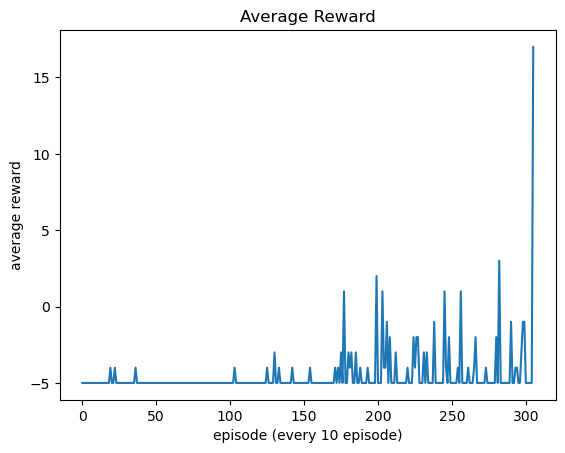

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(len(avg_rewards_list)), avg_rewards_list)
plt.title('Average Reward')
plt.xlabel('episode (every 10 episode)')
plt.ylabel('average reward')
plt.show()


## Report

由上圖可以看出，在train大概1,700個episode後就有很大機率可以飛過至少一根柱子，不過test reward大都不超過5，一直到train超過3,050個episode後test reward才有到17。